In [2]:
import datetime as dt
import pandas as pd
import numpy as np

from pandas_datareader import data as pdr
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

In [6]:
end = dt.datetime.now()
start =dt.datetime(2015,1,1)
df = pdr.get_data_yahoo(['^AXJO', 'CBA.AX', 'NAB.AX', 'STO.AX', 'WDS.AX'], start, end)
Close =df.Close
Close.head()

Symbols           ^AXJO     CBA.AX     NAB.AX    STO.AX     WDS.AX
Date                                                              
2015-01-01  5435.899902  85.277962  31.925041  7.132698  37.629452
2015-01-04  5450.299805  85.486832  31.972605  7.193661  37.826828
2015-01-05  5364.799805  84.840332  31.715757  6.575320  35.981377
2015-01-06  5353.600098  84.651360  31.791861  6.488230  35.665577
2015-01-07  5381.500000  84.929848  32.077248  6.357594  35.487938

In [7]:
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()

In [8]:
daily_std = log_returns.std()

daily_std

Symbols
^AXJO     0.010252
CBA.AX    0.014404
NAB.AX    0.015133
STO.AX    0.028162
WDS.AX    0.019548
dtype: float64

In [11]:
annualized_vol = daily_std *np.sqrt(252)
annualized_vol*100

Symbols
^AXJO     16.274033
CBA.AX    22.865461
NAB.AX    24.023138
STO.AX    44.705356
WDS.AX    31.031790
dtype: float64

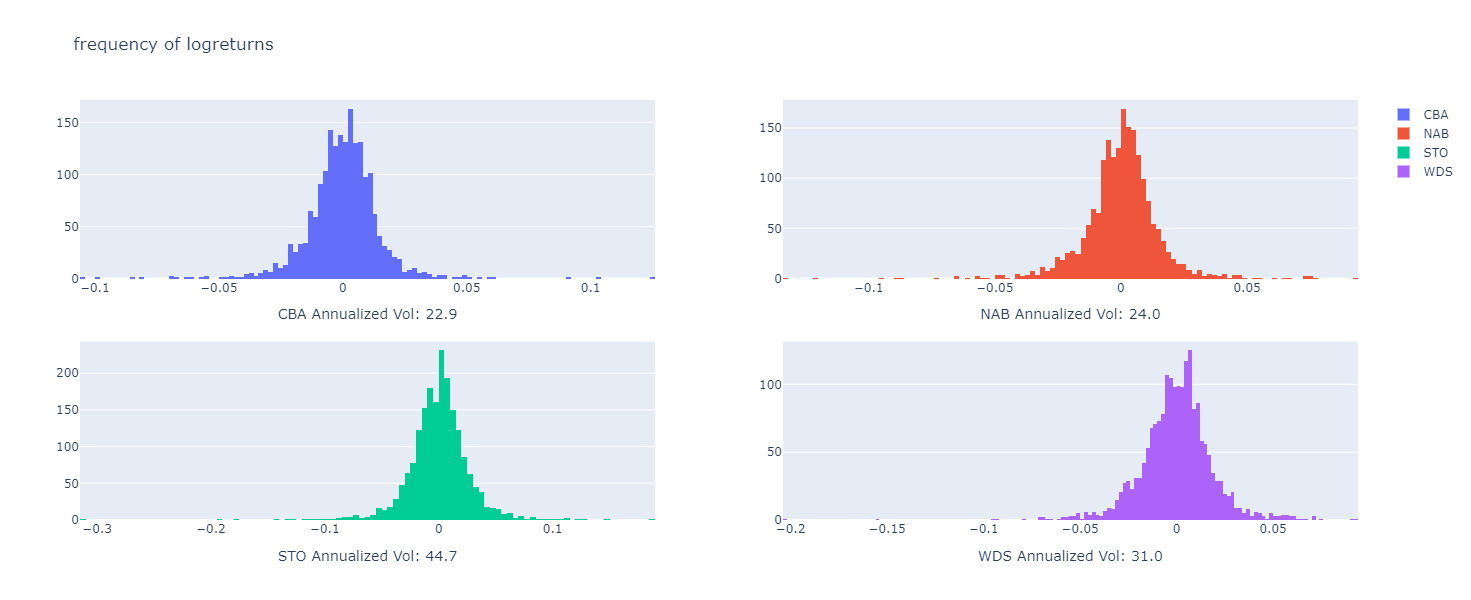

In [16]:
fig = make_subplots(rows=2, cols=2)
trace0 = go.Histogram(x=log_returns['CBA.AX'], name='CBA')
trace1 = go.Histogram(x=log_returns['NAB.AX'], name='NAB')
trace2 = go.Histogram(x=log_returns['STO.AX'], name='STO')
trace3 = go.Histogram(x=log_returns['WDS.AX'], name='WDS')

fig.append_trace(trace0, 1,1)
fig.append_trace(trace1, 1,2)
fig.append_trace(trace2, 2,1)
fig.append_trace(trace3, 2,2)

fig.update_layout(autosize=False, width=600, height=600, title= 'frequency of logreturns', xaxis=dict(title = 'CBA Annualized Vol: '+str(np.round(annualized_vol['CBA.AX']*100, 1))),
                  xaxis2=dict(title= 'NAB Annualized Vol: '+str(np.round(annualized_vol['NAB.AX']*100, 1))),
                  xaxis3=dict(title= 'STO Annualized Vol: '+str(np.round(annualized_vol['STO.AX']*100, 1))),
                  xaxis4=dict(title = 'WDS Annualized Vol: '+str(np.round(annualized_vol['WDS.AX']*100, 1)))
                 )

fig.show()


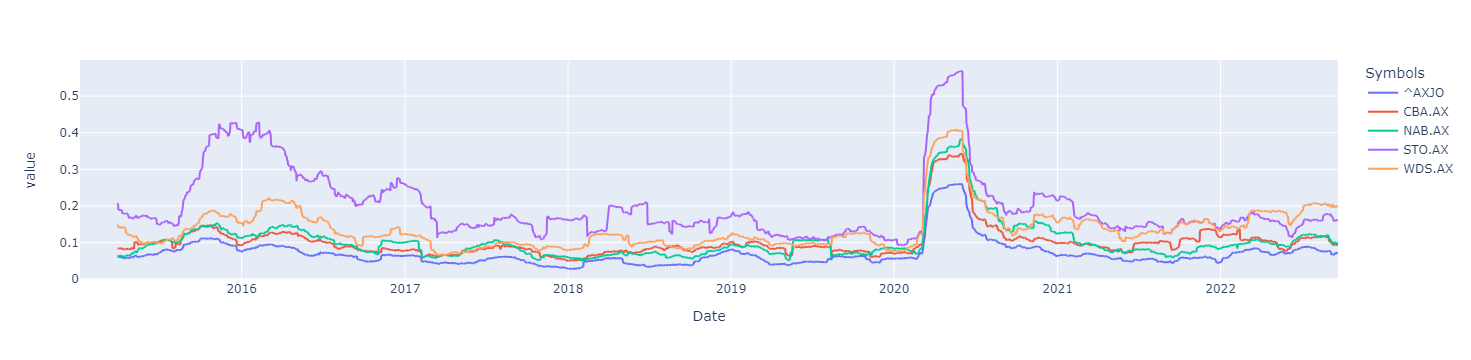

In [18]:
trading_days = 60
volatility = log_returns.rolling(window=trading_days).std()*np.sqrt(trading_days)
volatility.plot()


In [19]:
Rf = 0.01/252
sharpe_ratio = (log_returns.rolling(window=trading_days).mean() -Rf)*trading_days/volatility 

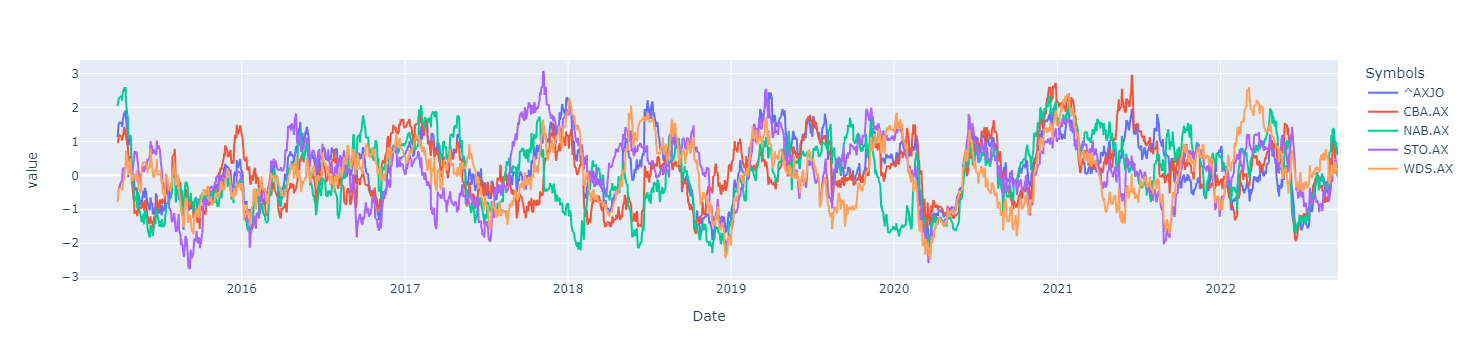

In [20]:
sharpe_ratio.plot()

In [21]:
sortino_vol = log_returns[log_returns <0].rolling(window=trading_days, center = True, min_periods= 10).std()*np.sqrt(trading_days)

In [22]:
sortino_ratio = (log_returns.rolling(window=trading_days).mean() -Rf)*trading_days/sortino_vol 

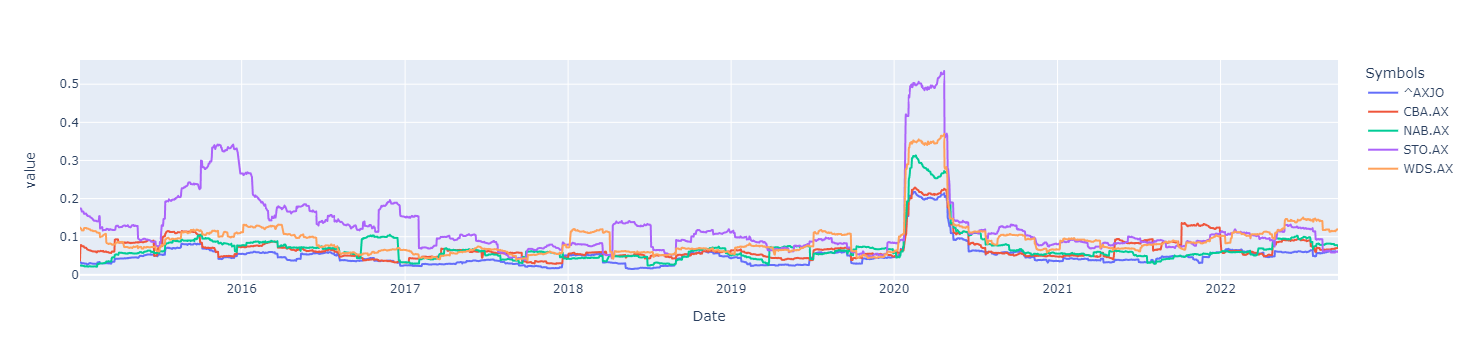

In [23]:
sortino_vol.plot()

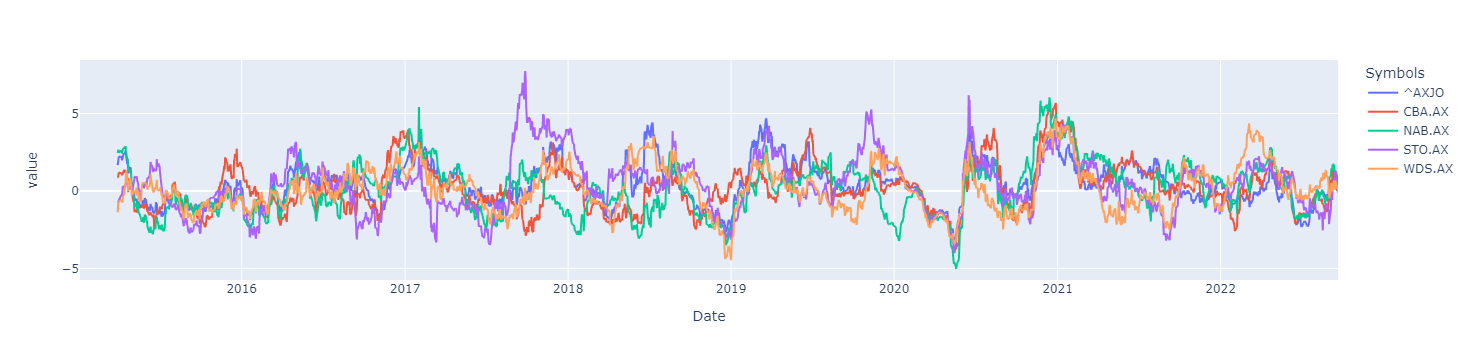

In [24]:
sortino_ratio.plot()

In [25]:
m2_ratio = pd.DataFrame()

benchmark_vol = volatility['^AXJO']
for c in log_returns.columns:
    if c != '^AXJO':
        m2_ratio[c] = (sharpe_ratio[c]*benchmark_vol/trading_days + Rf)*trading_days
        

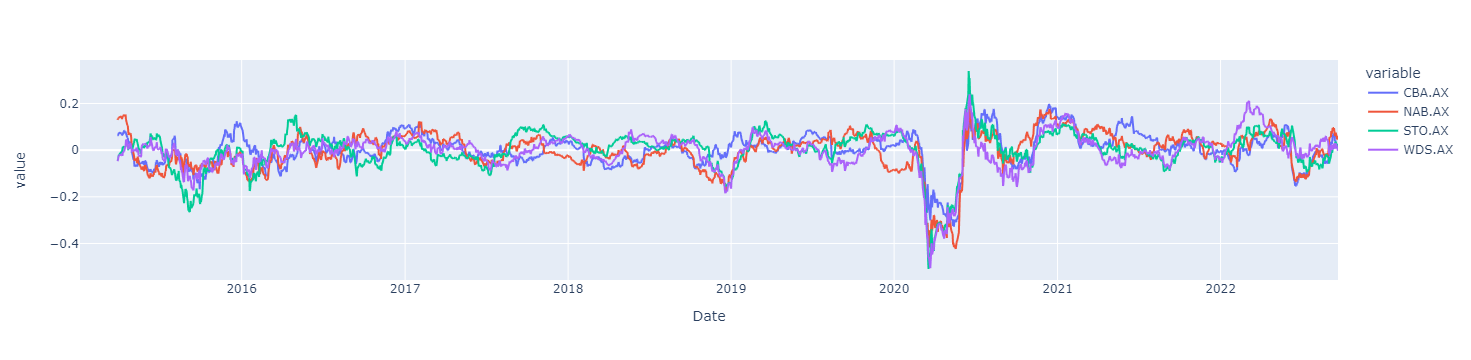

In [26]:
m2_ratio.plot()

In [27]:
def max_drawdown(returns):
    cumulative_returns = (1+returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns/peak) -1
    return drawdown.min()

returns = df.Close.pct_change().dropna()
max_drawdowns = returns.apply(max_drawdown, axis=0)
max_drawdowns*100

Symbols
^AXJO    -36.530541
CBA.AX   -43.361732
NAB.AX   -63.126540
STO.AX   -69.444444
WDS.AX   -60.846153
dtype: float64

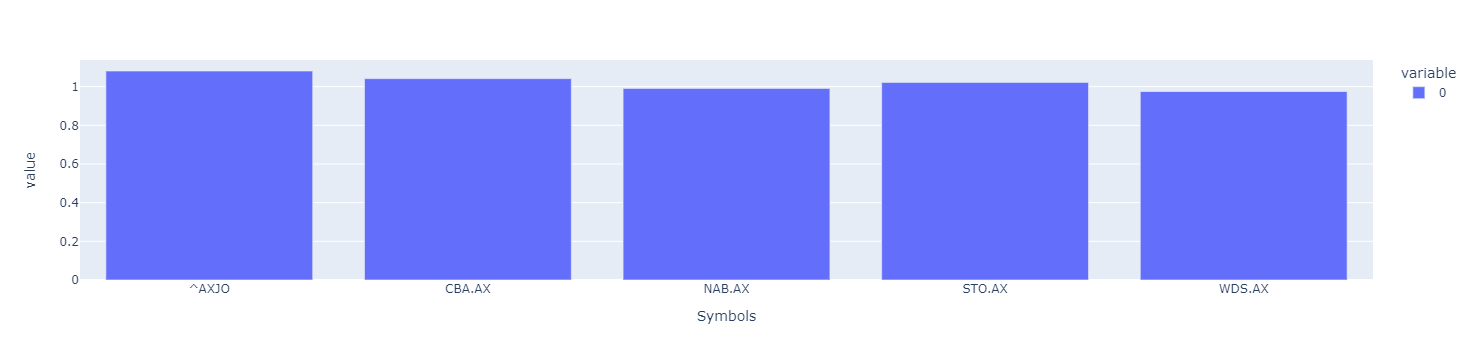

In [32]:
calmars = np.exp(log_returns.mean()*252/abs(max_drawdowns))
calmars.plot.bar()